![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 21 - Clasificación multiclase I

Hasta ahora siempre hemos estado trabajando con tareas de clasificación binaria, es decir, tareas en las que hay que elegir entre dos posibles clases.

Sin embargo, será habitual que nos tengamos que enfrentar a conjuntos de datos donde los ejemplos puedan pertenecer a más de dos clases. A estos problemas los conocemos como clasificación multiclase o multiclasificación.

En esta sesión práctica y en la siguiente veremos cómo trabajar con este tipo de problemas.

Vamos a cargar un conjunto de datos de tres clases y dos atributos para poder visualizarlo:


#####################################################
#### Cargamos conjunto de datos
#####################################################


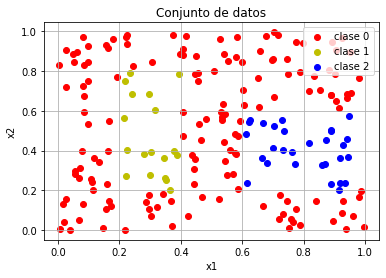

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier


def pinta(X_clase0, X_clase1, X_clase2, texto):
    fig, ax = plt.subplots()
    ax.scatter(X_clase0[:, 0], X_clase0[:, 1], c='r', label='clase 0')
    ax.scatter(X_clase1[:, 0], X_clase1[:, 1], c='y', label='clase 1')
    ax.scatter(X_clase2[:, 0], X_clase2[:, 1], c='b', label='clase 2')
    ax.set_xlabel('x1')
    ax.set_title(texto)
    ax.set_ylabel('x2')
    ax.legend(loc="upper right")
    ax.grid(True)
    plt.show()


print("\n#####################################################")
print("#### Cargamos conjunto de datos")
print("#####################################################")

df = pd.read_excel('ejemplo.xlsx', sheet_name='datos')
filas, columnas = df.shape

# separamos las primeras columnas y las almacenamos en X
X = df.iloc[:,0:(columnas-1)]

# separamos la clase
y = df.iloc[:,(columnas-1)]

pinta(X[y==0].values, X[y==1].values, X[y==2].values, 'Conjunto de datos')

Como vemos en la gráfica, las clases 1 y 2 ocupan zonas muy concretas del espacio y además cuentan con un menor número de ejemplos.

Las clases vendrán definidas por números diferentes, en este caso en el que tenemos 3 posibles clases podrían identificarse como {-1, 0, 1}, {1, 5, 10},... o de cualquier forma que se nos ocurra que sea un conjunto de números enteros. Personalmente, ya que en clasificación binaria hemos estado trabajando con {0, 1}, creo que una buena manera de identificar las clases es añadiendo los números consecutivos que se necesiten, resultando en este caso {0, 1, 2}. Muchas veces la nomenclatura de las clases nos vendrá impuesta, pero si no es así, tener un método claro para nombrarlas puede ser de utilidad.

Vamos a partir este conjunto dejando un 30% de los ejemplos para evaluar:

In [ ]:
print('\n##########################################')
print('### Hold-out 70-30')
print('##########################################')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234, stratify=y)

La forma de entrenar y evaluar no difiere en nada respecto a los problemas de clasificación binaria:

In [ ]:
# creamos un k-vecinos
sys_knn = KNeighborsClassifier()

# entrenamos
model = sys_knn.fit(X_train, y_train)

# evaluamos
y_pred = model.predict(X_test)

# obtenemos la accuracy
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

## 21.1 Matriz de confusión

Si queremos calcular la matriz de confusión podemos realizar los mismos pasos que ya vimos en una práctica anterior:

In [ ]:
# obtenemos las diferentes etiquetas que puede tener la clase
class_labels = df['clase'].unique()

print("Posibles valores de la clase:", class_labels)

# se calcula la matriz de confusión indicándole las etiquetas posibles
cm = metrics.confusion_matrix(y_test, y_pred, labels=class_labels)

print("Matriz de confusión:")
print(cm)

# se crea un DataFrame en el que el contenido es la matriz de confusión 
# y los índices son las posibles etiquetas de la clase
df_cm = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# se muestra el mapa de calor 
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión"), plt.tight_layout()
plt.ylabel("Clase verdadera"), plt.xlabel("Clase predicha")
plt.show()

En este caso, tenemos 3 filas y 3 columnas puesto que tenemos 3 clases. El número de filas y columnas siempre se corresponderá con el número de clases que tenga el conjunto de datos.

Vimos en una práctica anterior que en base a esta matriz de confusión calculábamos medidas como Precision, Recall y F1. Para realizar esos cálculos debemos contabilizar:
- TP (True Positive), número de ejemplos de la clase positiva a los que se les predice la clase positiva (aciertos)
- FP (False Positive), número de ejemplos de la clase negativa a los que se les predice la clase positiva (fallos)
- TN (True Negative), número de ejemplos de la clase negativa a los que se les predice la clase negativa (aciertos)
- FN (False Negative), número de ejemplos de la clase positiva a los que se les predice la clase negativa (fallos)

Sin embargo ahora tenemos 3 clases, así que para realizar estos cálculos debemos considerar una de las clases como la clase positiva y el resto de clases como la clase negativa y reconstruir la matriz de confusión de la siguiente manera suponiendo que tuviésemos $n$ clases:

![Matriz de confusión multiclase](fig_mccm.png) 

Imagen tomada de https://www.researchgate.net/publication/314116591_Activity_Context_and_Plan_Recognition_with_Computational_Causal_Behaviour_Models/figures?lo=1

Así, si consideramos como positiva la clase 0, resultaría la siguiente matriz de confusión:

In [ ]:
# defino cuál es la clase pivote y cuáles forman parte del resto
clase = 0
resto_a = 1
resto_b = 2
etiquetas_clases = [str(clase), 'resto']

# sumo las filas del resto de clases
verdadero_resto = cm[resto_a, :]+cm[resto_b ,:]

# creo la nueva matriz de confusión
cm_clase_resto = np.empty((2, 2), int)

# se realizan los cálculos adecuados para obtener TP, FP, TN, FN
cm_clase_resto[0, 0] = cm[clase, clase]
cm_clase_resto[1, 1] = verdadero_resto[resto_a] + verdadero_resto[resto_b]
cm_clase_resto[1, 0] = verdadero_resto[clase]
cm_clase_resto[0, 1] = cm[clase, resto_a] + cm[clase, resto_b]
print(cm_clase_resto)

# se crea un DataFrame en el que el contenido es la matriz de confusión 
# y los índices son las posibles etiquetas de la clase
df_cm = pd.DataFrame(cm_clase_resto, index=etiquetas_clases, columns=etiquetas_clases)

# se muestra el mapa de calor 
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión para la clase "+str(clase)), plt.tight_layout()
plt.ylabel("Clase verdadera"), plt.xlabel("Clase predicha")
plt.show()

Y sobre esta matriz ya podríamos realizar los cálculos de las medidas que deseásemos.

Si quisiésemos realizar los cálculos para la clase 1, tendríamos que obtener su matriz:

In [ ]:
# defino cuál es la clase pivote y cuáles forman parte del resto
clase = 1
resto_a = 0
resto_b = 2
etiquetas_clases = [str(clase), 'resto']

# sumo las filas del resto de clases
verdadero_resto = cm[resto_a, :]+cm[resto_b ,:]

# creo la nueva matriz de confusión
cm_clase_resto = np.empty((2, 2), int)

# se realizan los cálculos adecuados para obtener TP, FP, TN, FN
cm_clase_resto[0, 0] = cm[clase, clase]
cm_clase_resto[1, 1] = verdadero_resto[resto_a] + verdadero_resto[resto_b]
cm_clase_resto[1, 0] = verdadero_resto[clase]
cm_clase_resto[0, 1] = cm[clase, resto_a] + cm[clase, resto_b]
print(cm_clase_resto)

# se crea un DataFrame en el que el contenido es la matriz de confusión 
# y los índices son las posibles etiquetas de la clase
df_cm = pd.DataFrame(cm_clase_resto, index=etiquetas_clases, columns=etiquetas_clases)

# se muestra el mapa de calor 
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión para la clase "+str(clase)), plt.tight_layout()
plt.ylabel("Clase verdadera"), plt.xlabel("Clase predicha")
plt.show()

Y para obtener las medidas para la clase 2 tendríamos que calcular su propia matriz de confusión:

In [ ]:
# defino cuál es la clase pivote y cuáles forman parte del resto
clase = 2
resto_a = 1
resto_b = 0
etiquetas_clases = [str(clase), 'resto']

# sumo las filas del resto de clases
verdadero_resto = cm[resto_a, :]+cm[resto_b ,:]

# creo la nueva matriz de confusión
cm_clase_resto = np.empty((2, 2), int)

# se realizan los cálculos adecuados para obtener TP, FP, TN, FN
cm_clase_resto[0, 0] = cm[clase, clase]
cm_clase_resto[1, 1] = verdadero_resto[resto_a] + verdadero_resto[resto_b]
cm_clase_resto[1, 0] = verdadero_resto[clase]
cm_clase_resto[0, 1] = cm[clase, resto_a] + cm[clase, resto_b]
print(cm_clase_resto)

# se crea un DataFrame en el que el contenido es la matriz de confusión 
# y los índices son las posibles etiquetas de la clase
df_cm = pd.DataFrame(cm_clase_resto, index=etiquetas_clases, columns=etiquetas_clases)

# se muestra el mapa de calor 
sns.heatmap(df_cm, annot=True, cmap="Blues", fmt='d', cbar=False)
plt.title("Matriz de confusión para la clase "+str(clase)), plt.tight_layout()
plt.ylabel("Clase verdadera"), plt.xlabel("Clase predicha")
plt.show()

Una forma de obtener estas medidas para cada clase sin necesidad de calcular todas las matrices de confusión es utilizando la función `classification_report()`:

In [ ]:
# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred, digits=3))

Este informe nos muestra precision, recall y F1 de la matriz de confusión de cada una de las clases. Bajo el nombre `support` nos muestra el número de ejemplos de cada clase.

También nos muestra la accuracy del modelo y las medias ponderadas y sin ponderar:
- `macro avg` se correspondería con la media sin ponderar, es decir, suma el valor de una de las medidas para las tres clases y luego divide entre 3.
- `weighted avg` calcula la media ponderada en función del número de ejemplos.

Más información sobre esta función podemos encontrarla en: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report

Si queremos almacenar todos estos cálculos para luego operar con ellos, podemos indicarle a esta función mediante `output_dict=True` que genere un diccionario con los resultados:

In [ ]:
resultados = metrics.classification_report(y_test, y_pred, output_dict=True)
display(resultados)

## 21.2 Algoritmos preparados para tareas multiclase

No todos los algoritmos están preparados para trabajar con conjuntos de datos multiclase de manera natural. La mayoría de los algoritmos existentes están pensados para resolver problemas binarios aunque se pueden adaptar para tareas multiclase. Esto es algo que veremos en la próxima práctica.

De los algoritmos que hemos visto hasta el momento, únicamente `KNeighborsClassifier`, `GaussianNB`, `DecisionTreeClassifier` y `RandomForestClassifier` pueden resolver problemas de clasificación multiclase de manera directa.

En esta sesión hemos estado trabajando con `KNeighborsClassifier`. Veamos cómo son las regiones que define el modelo entrenado para este conjunto de datos:

In [ ]:
# con k-vecinos
sys_knn = KNeighborsClassifier(n_neighbors=5)
model = sys_knn.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_knn, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

Vemos que la naturaleza del k-vecinos hace que las regiones se adapten mucho. Si hubiésemos entrenado con un número de vecinos diferente las regiones cambiarían.

Si utilizamos Naïve Bayes obtendríamos lo siguiente:

In [ ]:
# con Naïve Bayes
sys_dt = GaussianNB()
model = sys_dt.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_dt, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

Vemos que en este caso las regiones se definen con formas de gaussianas centradas en las zonas con mayor densidad de ejemplos de cada clase.

Si buscamos una solución basada en árboles de decisión esto es lo que obtendremos:

In [ ]:
# con árboles de decisión
sys_dt = DecisionTreeClassifier(random_state=1234)
model = sys_dt.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_dt, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

En este caso vemos que aparecen zonas delimitadas mediante cortes paralelos (o perpendiculares) a los ejes. Esta es la forma natural de separar el espacio para los árboles de decisión.

En el caso de un Random Forest, que se basa en la combinación de árboles de decisión, veremos que en esencia el espacio se divide utilizando también cortes paralelos (o perpendiculares) a los ejes, pero en determinadas zonas del espacio esos rectángulos se adaptarán ligeramente:

In [ ]:
# con random forest
sys_rf = RandomForestClassifier(random_state=1234, n_jobs=-1)
model = sys_rf.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % metrics.accuracy_score(y_test, y_pred))

# mostramos el informe de clasificación
print(metrics.classification_report(y_test, y_pred))

# se genera el display con el espacio coloreado
disp = DecisionBoundaryDisplay.from_estimator(sys_rf, X, response_method="predict", cmap=plt.cm.RdYlBu, alpha=0.6, xlabel=X.columns[0], ylabel=X.columns[1])

# se incorporan los datos
disp.ax_.scatter(X.values[:,0], X.values[:,1], c=y, cmap=plt.cm.RdYlBu)

disp.ax_.set_xlim([0, 1])
disp.ax_.set_ylim([0, 1])
disp.ax_.set_title('Superficie de cada clase en el espacio de entrada')
plt.show()

## Ejercicios

1. Carga los datos de la pestaña "NPS" que hay en el fichero **CTG.xls**. 
2. Se debe calcular para los sistemas `KNeighborsClassifier`, `GaussianNB`, `DecisionTreeClassifier` y `RandomForestClassifier` las métricas accuracy y las medias ponderadas de precision, recall y F1.
3. Presentar los resultados en forma de tabla.

Estos ejercicios no es necesario entregarlos.